Episode: Joe Rogan Experience #2159 - Sal Vulcano, Named Entities: ['Michael Jackson', 'Rodney Dangerfield', 'Gary Oldman', 'Alfred Hitchcock', 'Nicki Minaj', 'Bobby Lee', 'Guy Ritchie', 'Alan King', 'Joe Rogan', 'Dick Gregory', 'Jeff Ross', 'Richard Pryor', 'George Carlin', 'Colin Farrell', 'Rodney To', 'Walt Disney', 'The Big Bopper', 'Don Rickles', 'Lenny Bruce', 'Dan Carlin']
Episode: Joe Rogan Experience #2158 - Harland Williams, Named Entities: ['Robin Williams', 'Jim Morrison', 'Angelina Jolie', 'Bruce Lee', 'I Did a Thing', 'Marlee Matlin', 'Dolly Parton', 'Judi Dench', 'Joe Rogan', 'Phil Hartman', 'Natalie Portman', 'O. J. Simpson', 'Diddy', 'Janis Joplin', 'Dave Foley', 'Lee Marvin', 'Judy Dent', 'Dick Van Dyke', 'Chuck Norris']
Episode: Joe Rogan Experience #2157 - Duncan Trussell, Named Entities: ['Johnny Thunder', 'Brad Pitt', 'Brian Redban', 'Arnold Schwarzenegger', 'Bobby Lee', 'Guy Ritchie', 'Al Gore', 'Joe Rogan', 'Aaliyah', 'Eric Weinstein', 'Jeff Ross', 'Terrence How

/Users/claudio/anaconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


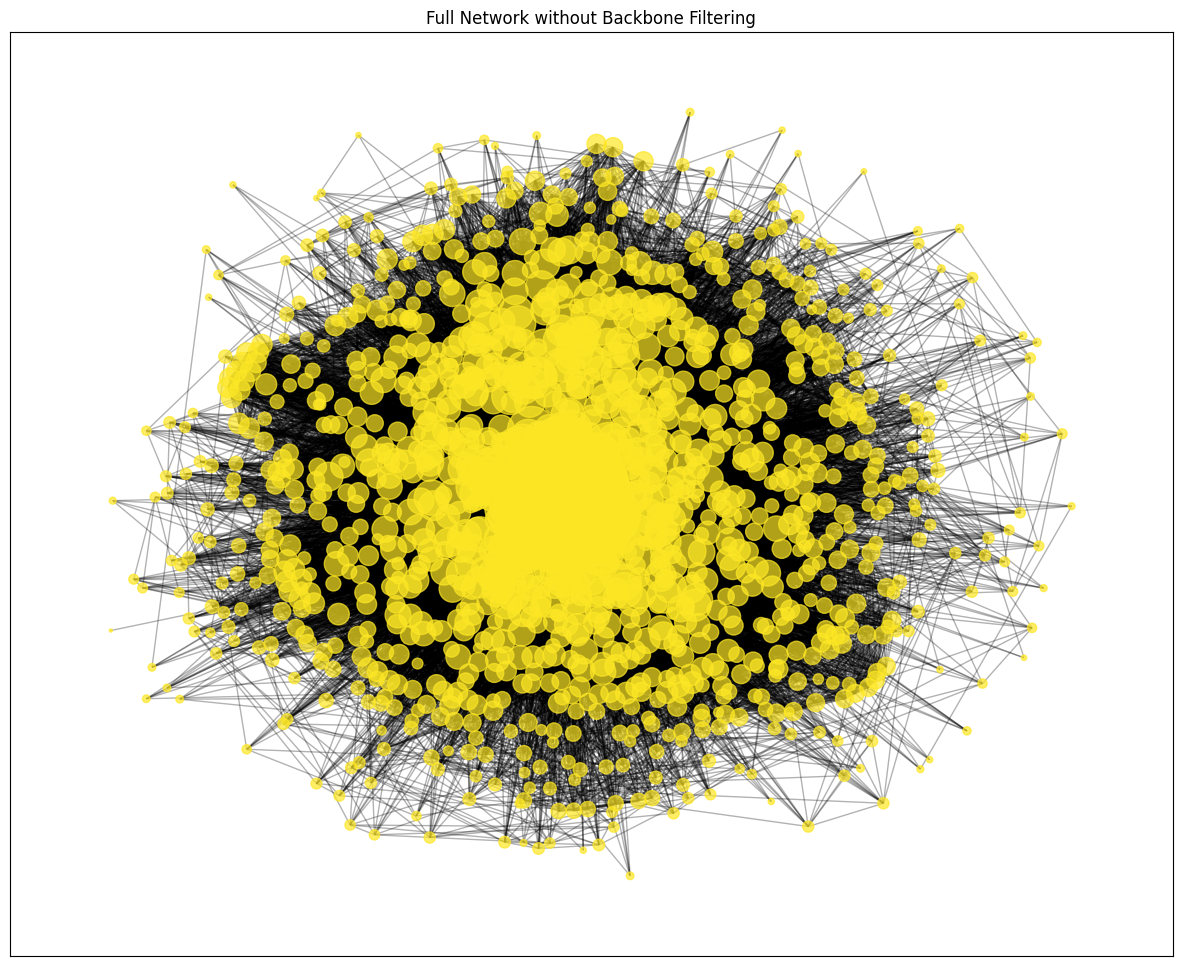

/var/folders/s9/jn1j68g52x51mn_2d_mzfk300000gn/T/ipykernel_30377/485926530.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set3', len(communities))


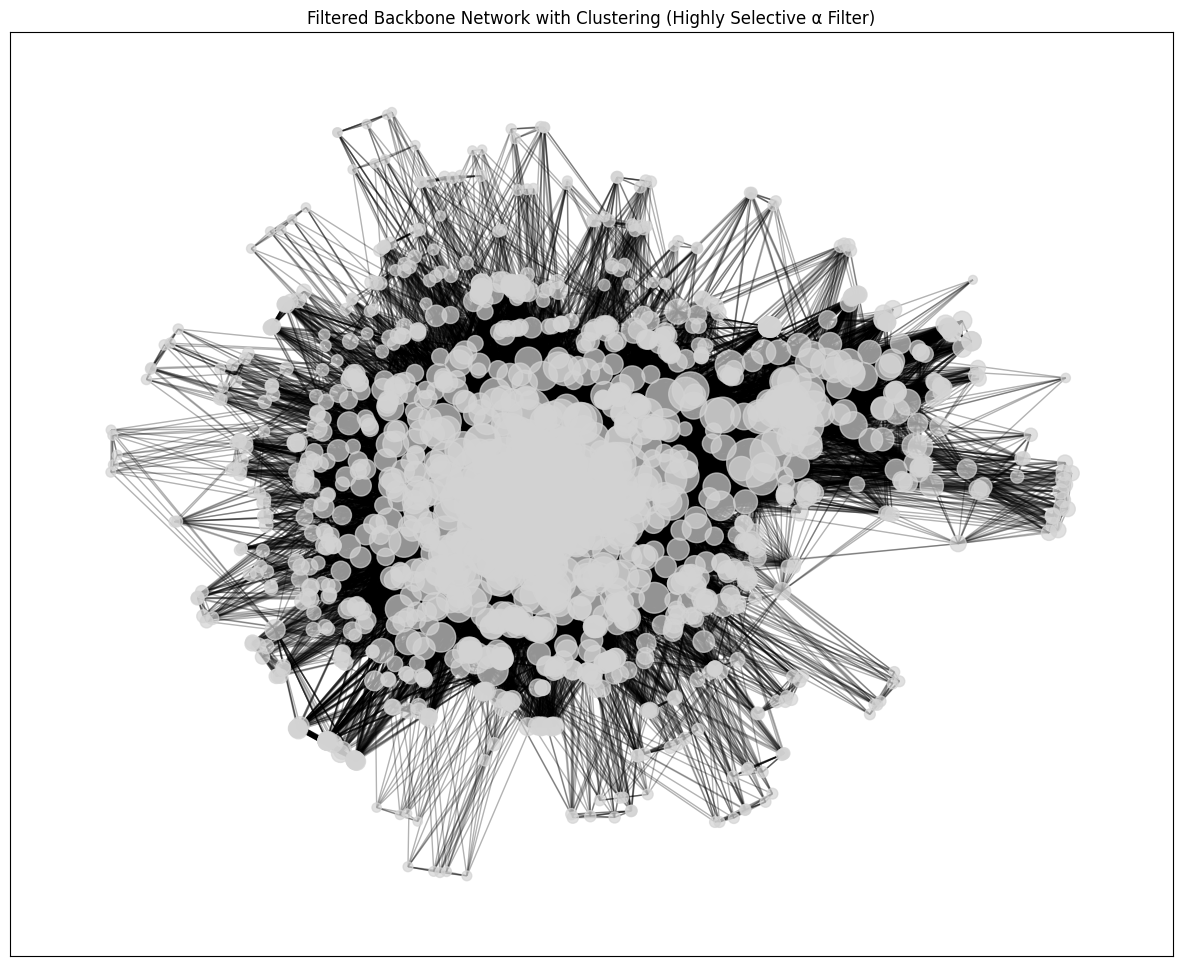

In [3]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm

# Load JSON data
with open('updated_jre_episodes_data.json', 'r', encoding='utf-8') as file:
    episodes_data = json.load(file)

# Load Excel data
excel_data = pd.read_excel('jre_episodes_data.xlsx')

# Use the entire dataset for visualization
episodes_subset = episodes_data

# Initialize an empty directed graph
directed_graph = nx.DiGraph()

# Dictionary to track co-occurrences of named entities across episodes
co_occurrences = defaultdict(int)
entity_frequency = defaultdict(int)

# Iterate over each episode in the subset of JSON data
for episode in episodes_subset:
    named_entities = list(set(episode.get("people_mentioned", [])))  # Remove duplicates within the same episode

    # Track the frequency of each entity
    for entity in named_entities:
        entity_frequency[entity] += 1

    # Debug: Check if named entities are present in each episode
    if not named_entities:
        print(f"No named entities found in episode: {episode.get('Episode_Title', 'Unknown Title')}")
        continue

    print(f"Episode: {episode.get('Episode_Title', 'Unknown Title')}, Named Entities: {named_entities}")

    # Create edges between named entities mentioned in the same episode
    for i in range(len(named_entities)):
        for j in range(i + 1, len(named_entities)):
            entity_a = named_entities[i]
            entity_b = named_entities[j]
            
            # Increment the weight for the edge if it already exists, otherwise create it
            if entity_a != entity_b:
                if directed_graph.has_edge(entity_a, entity_b):
                    directed_graph[entity_a][entity_b]['weight'] += 1
                else:
                    directed_graph.add_edge(entity_a, entity_b, weight=1)

# Convert directed graph to undirected graph for visualization
undirected_graph = directed_graph.to_undirected()

# Determine the most frequent entities (e.g., top 20 entities)
most_frequent_entities = {entity for entity, count in sorted(entity_frequency.items(), key=lambda x: x[1], reverse=True)[:10]}

# Print the most frequent entities
print("Most frequent entities:")
for entity in most_frequent_entities:
    print(entity)

# Visualize the entire graph without backbone filtering
if len(undirected_graph.nodes) > 0:
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(undirected_graph, seed=42, k=0.5)  # Increase k to space out nodes more
    nx.draw_networkx_nodes(undirected_graph, pos, node_size=[undirected_graph.degree(node) * 5 for node in undirected_graph], alpha=0.7, node_color=colors(i))
    nx.draw_networkx_edges(undirected_graph, pos, alpha=0.3)
    plt.title('Full Network without Backbone Filtering')
    plt.show()
else:
    print("The full graph is empty. No nodes or edges to display.")

# Extract the giant connected component from the undirected graph
gcc = max(nx.connected_components(undirected_graph), key=len)
backbone_graph = undirected_graph.subgraph(gcc).copy()

# Apply a highly selective backbone filter using α parameter
alpha = 0.99  # Set an even more selective value for α
# Note: Implement your own backbone filter logic or use an existing library to apply the filter

# Apply clustering to identify communities within the backbone network
communities = list(nx.community.greedy_modularity_communities(backbone_graph))

# Filter nodes with a higher degree threshold to reduce complexity
degree_threshold = 7
filtered_nodes = [node for node in backbone_graph.nodes if backbone_graph.degree(node) > degree_threshold]
filtered_backbone_graph = backbone_graph.subgraph(filtered_nodes).copy()

# Check if the filtered graph has nodes before attempting to draw it
if len(filtered_backbone_graph.nodes) > 0:
    # Visualize the filtered backbone using Fruchterman-Reingold layout for better separation
    pos = nx.fruchterman_reingold_layout(filtered_backbone_graph, seed=42)
    plt.figure(figsize=(15, 12))
    colors = cm.get_cmap('Set3', len(communities))

    # Draw nodes and color them based on their community
    for i, community in enumerate(communities):
        community_nodes = [node for node in community if node in filtered_backbone_graph]
        nx.draw_networkx_nodes(filtered_backbone_graph, pos, nodelist=community_nodes, node_size=[filtered_backbone_graph.degree(node) * 5 for node in community_nodes], alpha=0.7, node_color='lightgrey')
    
    nx.draw_networkx_edges(filtered_backbone_graph, pos, alpha=0.3)
    plt.title('Filtered Backbone Network with Clustering (Highly Selective α Filter)')
    plt.show()
else:
    print("The filtered backbone graph is empty. No nodes or edges to display.")
